In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#loading rating dataset
ratings = pd.read_csv("/content/ratings (1).csv")
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
# loading movie dataset
movies = pd.read_csv("/content/movies (1).csv")
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [5]:
user_freq = ratings[['userId', 'movieId']].groupby(
    'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head())

   userId  n_ratings
0       1        232
1       2         29
2       3         39
3       4        216
4       5         44


In [6]:
# Find Lowest and Highest rated movies:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [7]:
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix

def create_matrix(df):

    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

In [8]:
"""
Find similar movies using KNN
"""
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):

	neighbour_ids = []

	movie_ind = movie_mapper[movie_id]
	movie_vec = X[movie_ind]
	k+=1
	kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
	kNN.fit(X)
	movie_vec = movie_vec.reshape(1,-1)
	neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
	for i in range(0,k):
		n = neighbour.item(i)
		neighbour_ids.append(movie_inv_mapper[n])
	neighbour_ids.pop(0)
	return neighbour_ids


movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 3

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}")
for i in similar_ids:
	print(movie_titles[i])


Since you watched Grumpier Old Men (1995)
Grumpy Old Men (1993)
Striptease (1996)
Nutty Professor, The (1996)
Twister (1996)
Father of the Bride Part II (1995)
Broken Arrow (1996)
Bio-Dome (1996)
Truth About Cats & Dogs, The (1996)
Sabrina (1995)
Birdcage, The (1996)


In [9]:
def recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
	df1 = ratings[ratings['userId'] == user_id]

	if df1.empty:
		print(f"User with ID {user_id} does not exist.")
		return

	movie_id = df1[df1['rating'] == max(df1['rating'])]['movieId'].iloc[0]

	movie_titles = dict(zip(movies['movieId'], movies['title']))

	similar_ids = find_similar_movies(movie_id, X, k)
	movie_title = movie_titles.get(movie_id, "Movie not found")

	if movie_title == "Movie not found":
		print(f"Movie with ID {movie_id} not found.")
		return

	print(f"Since you watched {movie_title}, you might also like:")
	for i in similar_ids:
		print(movie_titles.get(i, "Movie not found"))


In [10]:
user_id = 150
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)


Since you watched Twelve Monkeys (a.k.a. 12 Monkeys) (1995), you might also like:
Pulp Fiction (1994)
Terminator 2: Judgment Day (1991)
Independence Day (a.k.a. ID4) (1996)
Seven (a.k.a. Se7en) (1995)
Fargo (1996)
Fugitive, The (1993)
Usual Suspects, The (1995)
Jurassic Park (1993)
Star Wars: Episode IV - A New Hope (1977)
Heat (1995)


In [11]:
user_id = 316
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)


Since you watched To Die For (1995), you might also like:
Candidate, The (1972)
Age of Innocence, The (1993)
Bullets Over Broadway (1994)
Bob Roberts (1992)
Dead Men Don't Wear Plaid (1982)
Sweet Hereafter, The (1997)
Eat Drink Man Woman (Yin shi nan nu) (1994)
Heaven Can Wait (1978)
Get Shorty (1995)
State and Main (2000)


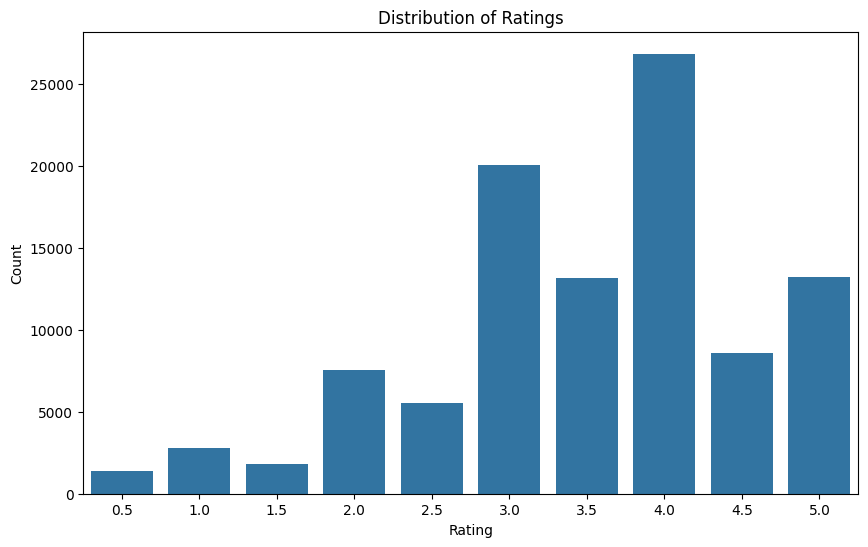

In [12]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

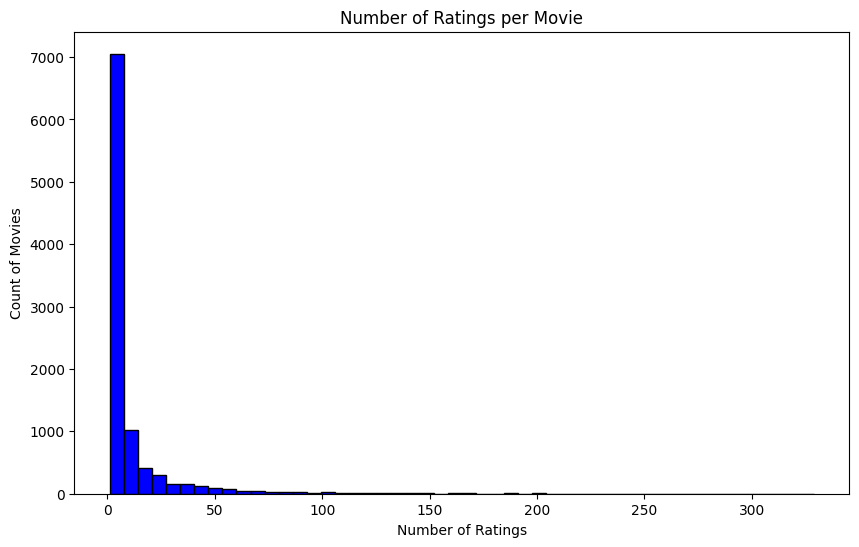

In [13]:
# Number of Ratings per Movie
movie_ratings = ratings.groupby('movieId').size()
plt.figure(figsize=(10, 6))
plt.hist(movie_ratings, bins=50, color='blue', edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()


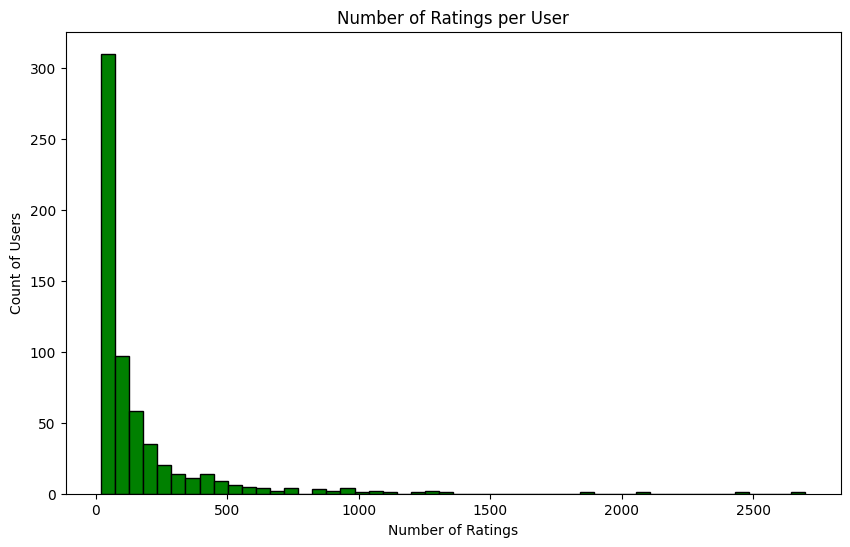

In [14]:
# Number of Ratings per User
user_ratings = ratings.groupby('userId').size()
plt.figure(figsize=(10, 6))
plt.hist(user_ratings, bins=50, color='green', edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

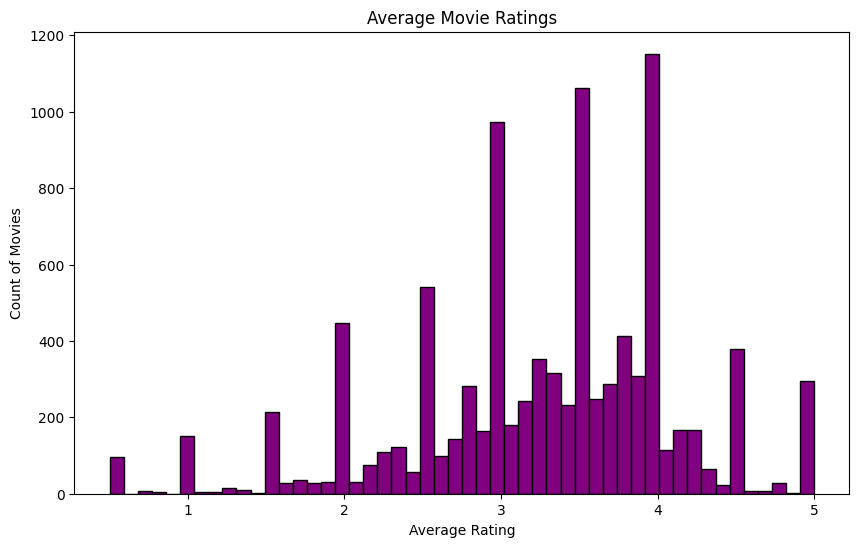

In [15]:
# Average Movie Ratings
mean_ratings = ratings.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
plt.hist(mean_ratings, bins=50, color='purple', edgecolor='black')
plt.title('Average Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count of Movies')
plt.show()